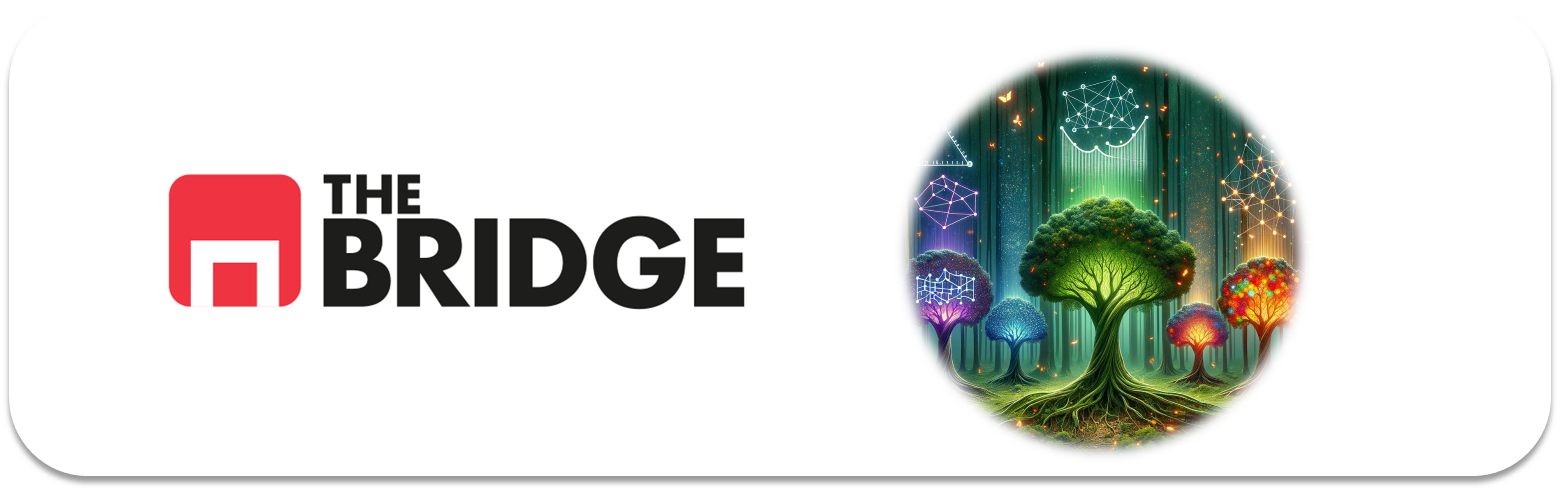

## PRACTICA OBLIGATORIA: **Ensamblado de modelos, bagging, boosting, random forest y gbts**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de obtención del mejor modelo para la resolución de un problema de clasificación sobre diabetes en la india. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descargar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

In [1]:
# !pip install imbalanced-learn

`IMPORTANTE`: He tenido que hacer un downgrade de numpy (de 2.1.1 a 1.26.4) a través de `pip install --upgrade catboost` (él solo ha gestionado el downgrade de numpy), para no tener problemas de compatibilidad entre catboost y numpy.

Después desharé el downgrade de numpy.

In [2]:
# !pip install --upgrade catboost

import numpy
numpy.__version__

'1.26.4'

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [3]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay 
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

import datascience as ds
import machinelearningtools as ml
import vizdatatools as viz

### Descripción del dataset

El dataset de los Pima Indians Diabetes contiene datos de un grupo de mujeres de al menos 21 años de edad de ascendencia india Pima que viven cerca de Phoenix, Arizona, EE. UU. Las características del dataset incluyen varios predictores médicos y un objetivo que indica si la paciente desarrolló diabetes dentro de cinco años.

### Características del Dataset

Las variables incluidas en el dataset son:

1. **Número de Embarazos**: Cantidad de veces embarazada.
2. **Concentración de Glucosa en Plasma**: Concentración de glucosa en plasma a 2 horas en una prueba de tolerancia oral a la glucosa.
3. **Presión Arterial Diastólica**: Presión arterial diastólica (mm Hg).
4. **Grosor del Pliegue Cutáneo del Tríceps**: Grosor del pliegue cutáneo del tríceps (mm).
5. **Insulina en Suero**: Insulina en suero a 2 horas (mu U/ml).
6. **Índice de Masa Corporal**: Peso en kg/(altura en m)^2.
7. **Función del Pedigree de Diabetes**: Una función que representa la predisposición genética a la diabetes.
8. **Edad**: Edad en años.
9. **Variable Objetivo**: Indica si la paciente desarrolló diabetes (1) o no (0).

### Carga de datos

El dataset lo puedes encontrar en la siguiente url y a continuación se proporciona una lista de nombres sugeridos para las columnas:


In [4]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

df_diabetes = pd.read_csv(url, names=names)


### Enunciado

Construye el mejor modelo que puedas para `predecir a partir de los datos de entrada si una mujer de la tribu Pima desarrollará diabetes`. 

Para ello `obtén al menos tres modelos a partir de tecnologías de bagging y boosting (al menos uno de cada)`, compáralos sin utilizar el test y selecciona uno de ellos como el mejor (justificándolo). Termina el ejercicio probando el modelo seleccionado y con sus hiperparámetros optimizados contra un dataset de test que deberás haber reservado con anterioridad.

# 1. Ojear brevemente los datos, distinguir *target*, *features* y tipo de problema.

In [5]:
df_diabetes.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   test    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
ds.get_cardinality(df_diabetes)

pandas.DataFrame shape:  (768, 9)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
preg,17,2.213542,0,0.0,int64,Numeric - Discrete
plas,136,17.708333,0,0.0,int64,Numeric - Discrete
pres,47,6.119792,0,0.0,int64,Numeric - Discrete
skin,51,6.640625,0,0.0,int64,Numeric - Discrete
test,186,24.21875,0,0.0,int64,Numeric - Discrete
mass,248,32.291667,0,0.0,float64,Numeric - Continuous
pedi,517,67.317708,0,0.0,float64,Numeric - Continuous
age,52,6.770833,0,0.0,int64,Numeric - Discrete
class,2,0.260417,0,0.0,int64,Binary


Todas las variables son numéricas, no hay valores missing y es un problema de clasificación binaria, donde nuestro target es "class"

# 2. Separar train y test

In [8]:
# Features y target
X = df_diabetes.drop(columns=['class'])
y = df_diabetes['class']

# Distribución del target
y.value_counts()


class
0    500
1    268
Name: count, dtype: int64

Tengo un problema de clasificación binaria con clases desbalanceadas. El desequilibrio puede afectar el rendimiento de los modelos de predicción, ya que puede tender a favorecer la clase mayoritaria. Algunas estrategias podrían ser:

1. Undersampling. Submuestreo de la clase mayoritaria. No quiero hacerlo porque no tengo tantos datos como para eliminar.
2. Oversampling. Sobremuestreo de la clase minoritaria. Aumenta el número de instancias de la clase minoritaria replicando las existentes o generando nuevos datos sintéticos.
3. Ajustar el peso de las clases. En scikit-learn, algunos modelos como LogisticRegression, RandomForestClassifier o SVM tienen un parámetro class_weight='balanced' que ajusta automáticamente los pesos de las clases según su frecuencia.
4. Evitar usar métricas como "accuracy" porque puede ser engañosa en este caso (un modelo puede predecir siempre la clase mayoritaria y aún así obtener una alta precisión). Mejor fijarme en F1-score, AUC-ROC, Recall, o Matriz de confusión.
5. Ajustar el umbral de probabilidad que utiliza el modelo para clasificar una instancia como perteneciente a la clase mayoritaria o minoritaria. Reducir el umbral puede mejorar la capacidad de capturar la clase minoritaria.


Opto por hacer un oversampling con la libreria imbalanced-learn

In [9]:
# Generar nuevas instancias a través de Synthetic Minority Over-sampling Technique (SMOTE)
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

y_resampled.value_counts()

class
1    500
0    500
Name: count, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,
                                                    y_resampled,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_resampled
                                                    )

print(y_train.value_counts())
print(y_test.value_counts())

class
1    400
0    400
Name: count, dtype: int64
class
1    100
0    100
Name: count, dtype: int64


# 3. Mini EDA


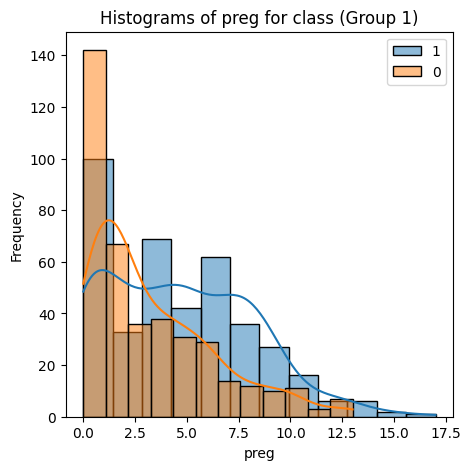

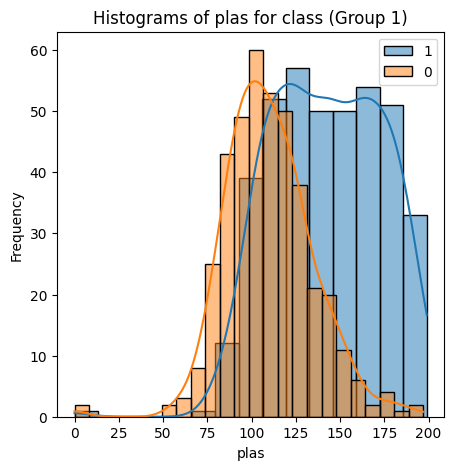

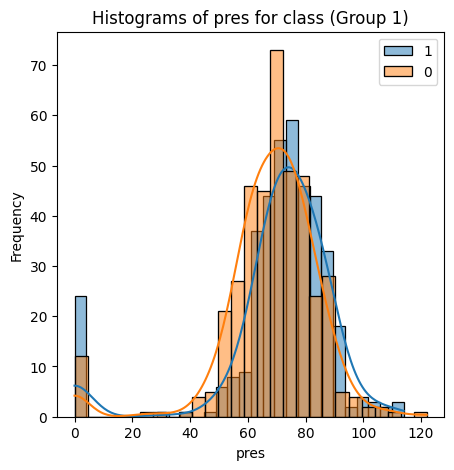

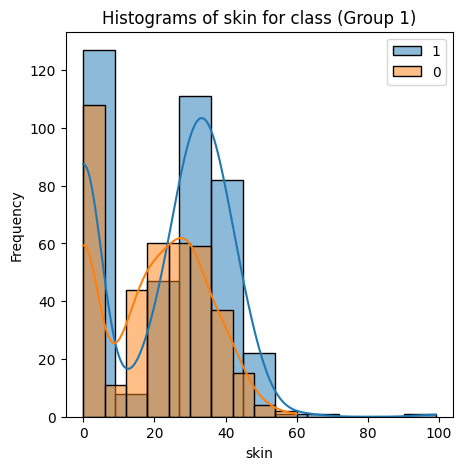

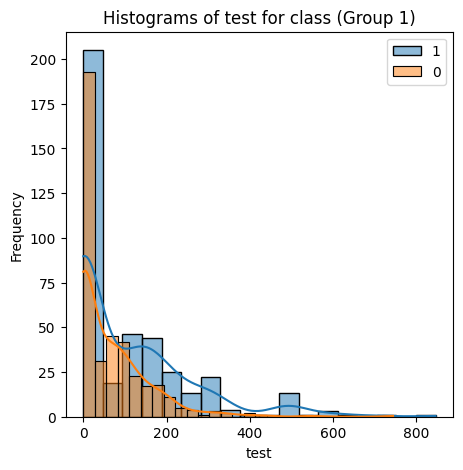

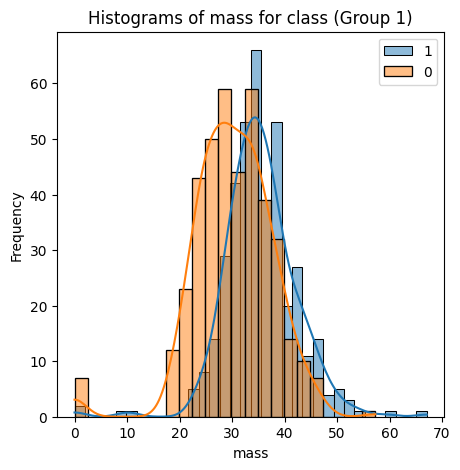

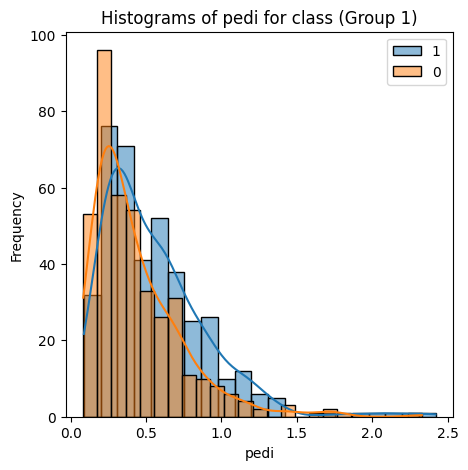

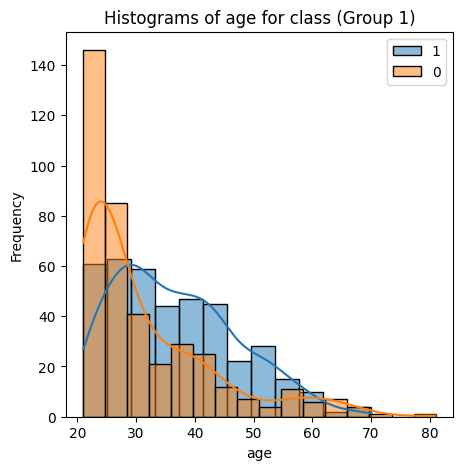

In [11]:
# Análisis bivariante de las columnas numéricas con la categórica (target)
for column in X_train.columns:
    # viz.plot_categorical_numerical_relationship(pd.concat([X_train, y_train], axis=1),
    #                                             'class',
    #                                             column
    #                                             )

    viz.plot_histograms_grouped(pd.concat([X_train, y_train], axis=1),
                                'class',
                                column
                                )

En todos los histogramas, los KDE se cruzan o tienen formas distintas, así que a priori son buenos estimadores para la clasificación.

Y el dataset no tiene ninguna feature categórica.

# 4. Tratamiento de features numéricas

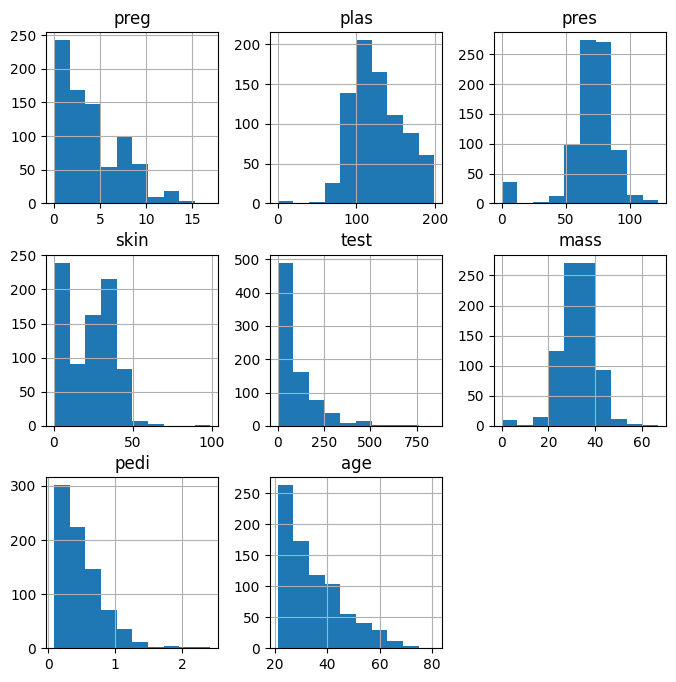

In [12]:
# X_train puro con su distribución
X_train.hist(figsize=(8, 8));

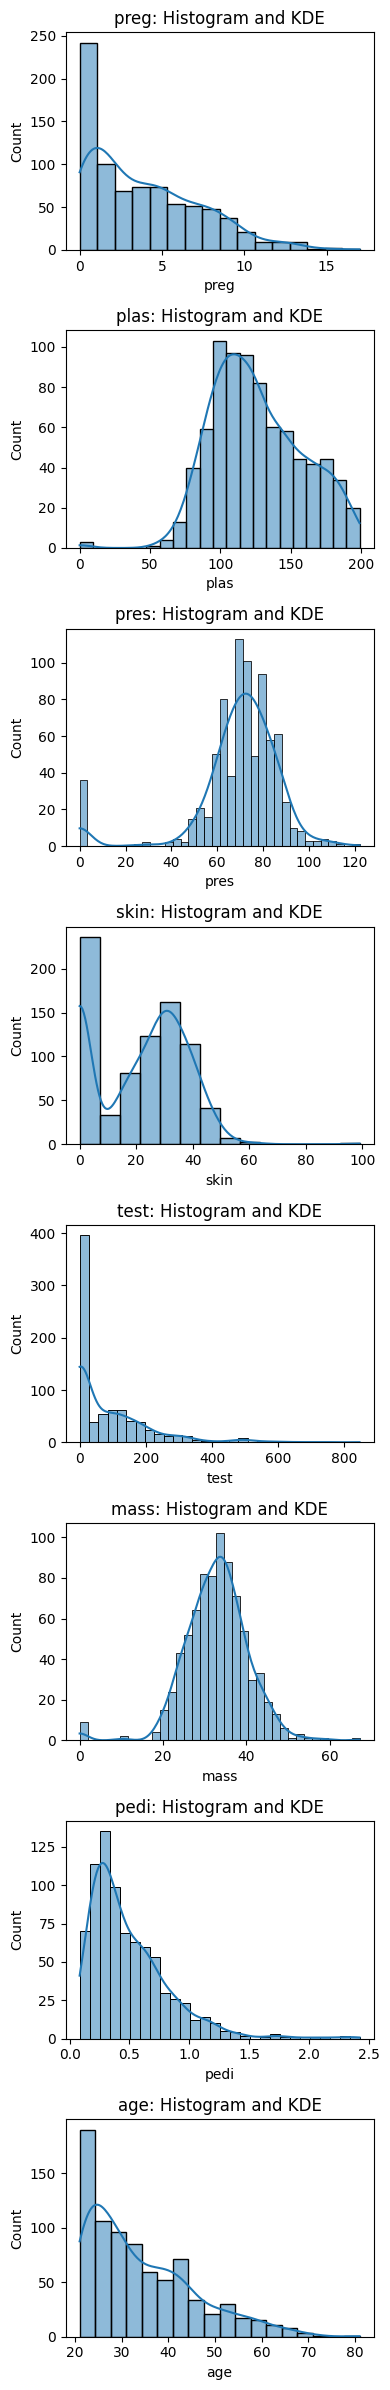

In [13]:
# Una representeción un poco más elegante (aunque ocupa mucho más)
viz.plot_multiple_histograms_KDEs_boxplots(X_train,
                                           X_train.columns,
                                           boxplot=False
                                           )


Es genéral, (casi) todos los modelos agradecen tener las variables numéricas con una distribución normal, por eso voy a aplicar el logaritmo a las más "desbalanceadas" (esta igual no es la palabra correcta).

In [14]:
# Aplicar el logaritmo de manera segura
def safe_log(column):
    """
    Aplicar el logaritmo de manera segura, para evitar hacer log(0) o de números negativos.
    """
    # Desplazar los valores si hay alguno <= 0
    min_val = column.min()
    if min_val <= 0:
        column = column - min_val + 1
    return np.log(column)

# Después de analizar los hist(), quiero aplicar el log sobre las siguientes columnas.
# Lo aplico ya sobre test y train
for column in ['preg', 'skin', 'test', 'pedi', 'age']:
    X_train[column] = safe_log(X_train[column])
    X_test[column] = safe_log(X_test[column])

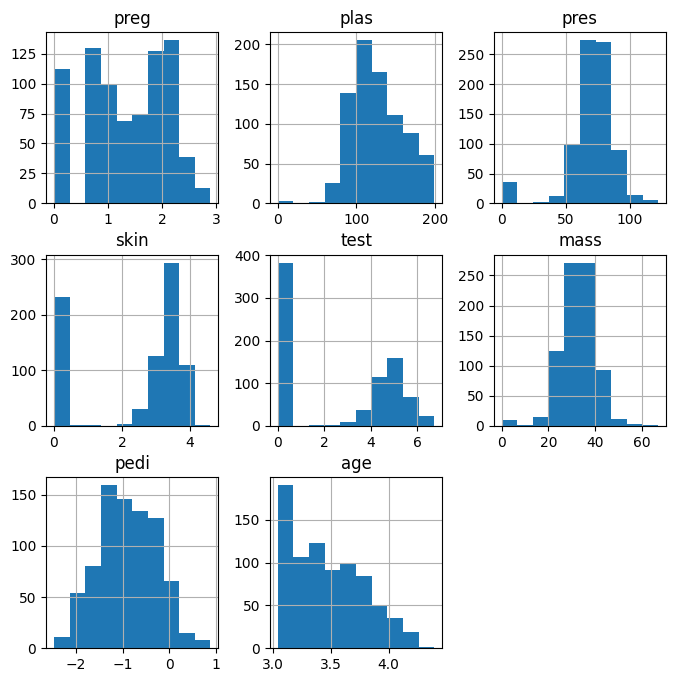

In [15]:
# Nueva varianza tras la aplicación del logaritmo
X_train.hist(figsize=(8, 8));

A los árboles no les importa, pero para el modelo de `regresión logística es interesante que los valores estén escalados (o normalizados).`

In [16]:
std_scaler = StandardScaler()
X_train = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(std_scaler.transform(X_test), columns=X_test.columns)

In [17]:
X_train.describe()

,preg,plas,pres,skin,test,mass,pedi,age
count,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02
mean,2.664535e-17,1.154632e-16,1.776357e-16,-4.440892e-17,2.220446e-17,-1.887379e-16,1.931788e-16,-2.708944e-16
std,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00
min,-1.755549e+00,-3.911070e+00,-3.639173e+00,-1.530551e+00,-1.020400e+00,-4.303575e+00,-2.506453e+00,-1.381912e+00
25%,-8.525155e-01,-7.497641e-01,-2.896789e-01,-1.530551e+00,-1.020400e+00,-5.780454e-01,-7.282498e-01,-8.244401e-01
50%,5.051820e-02,-1.299002e-01,1.290079e-01,5.549416e-01,4.307140e-01,3.627535e-02,-1.685344e-02,-1.366502e-01
75%,7.795869e-01,6.759229e-01,5.476947e-01,7.266562e-01,9.538411e-01,6.134958e-01,7.568211e-01,7.572851e-01
max,2.010034e+00,2.256576e+00,2.745800e+00,1.417197e+00,1.688877e+00,4.494128e+00,2.837584e+00,2.934299e+00


In [18]:
X_test.describe()

,preg,plas,pres,skin,test,mass,pedi,age
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,-0.024776,-0.010266,-0.005234,0.030188,0.005515,0.032161,-0.032535,-0.064993
std,1.010676,1.087848,1.130538,1.004391,1.033835,1.000151,1.008575,1.001117
min,-1.755549,-3.911070,-3.639173,-1.530551,-1.020400,-4.303575,-2.624296,-1.381912
25%,-0.852515,-0.757512,-0.289679,-1.530551,-1.020400,-0.628874,-0.748489,-0.954963
50%,0.050518,-0.036921,0.129008,0.554942,0.406901,0.012167,-0.058381,-0.241491
75%,0.779587,0.768902,0.652366,0.767628,1.024122,0.576171,0.748458,0.757285
max,1.856586,2.101610,1.908427,1.034525,1.601214,3.109880,2.455838,2.374947


> Las transformaciones lineales NO modifican la varianza, por eso el logaritmo lo hemos hecho antes. Se pueden ver de nuevo la forma de los histogramas.

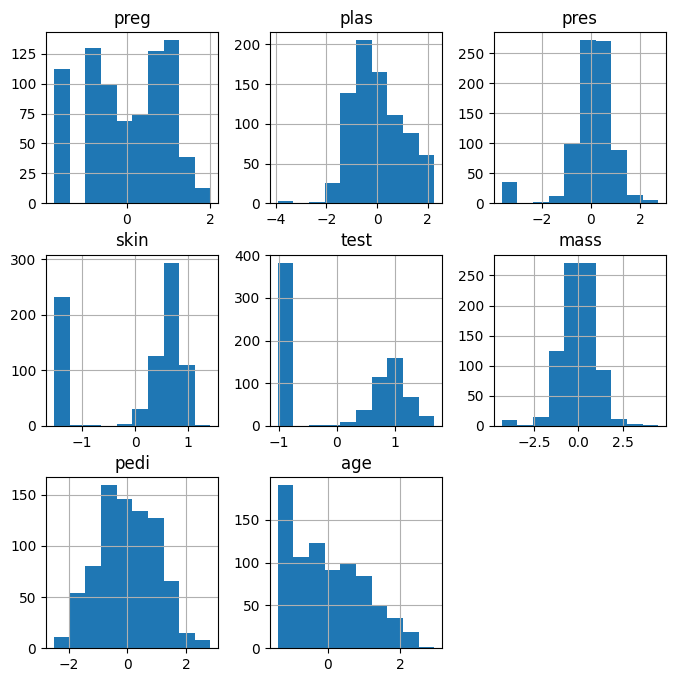

In [19]:
# Histogramas después de las estandarización
X_train.hist(figsize=(8, 8));

# 5. Entrenamiento de modelos con optimización previa

Voy a hacer un validación cruzada de modelos com `optimización de parámetros` mediante *Grid Searh*. Es más costoso en términos computacionales que *Random Search* y que *Bayesian Search*, pero... tengo tiempo para probarlo.

Lo modelos que voy a emplear son:
- LogisticRegression. Quiero usarlo de la forma tradicional ya que he preparado tanto las columnas numéricas; pero después también combinarlo con el modelo base de BaggingClassifier para utilizar técnica de Bagging.
- RandomForest. (Bagging). Es a un bagging de DecisionTreeClassifier (o al menos eso creo).
- AdaBoostClassifier (Boosting)
- GradientBoostingRegressor (Boosting)
- XGBClassifier (Boosting)
- LGBMClassifier (Boosting)
- CatBoostClassifier (Boosting)

La métrica en la que me voy a fijar es "accuracy" porque ya me he encargado al principio de hacer el oversampling, así que ahora sí tiene sentido mirarlo. Es cierto, que tengo dudas de si esto es correcto al ser los nuevos datos "sintéticos".

In [20]:
# Voy acumulando todas las metricas en un diccionario para poder acceder a ellos más rápidamente después
metricas_optimizadas = {}

In [21]:
# Logistic Regression tradicional. Métricas optimizadas

# Hiperparámetros de LogisticRegression
lr_param_grid = {
    "max_iter": [1000, 2000, 5000, 10000],
    "penalty": ["l2", None],
    "C": [0.1, 0.5, 1],
} 

# Configurar el GridSearchCV para LogisticRegression
lr_grid = GridSearchCV(LogisticRegression(random_state=42),
                       lr_param_grid,
                       cv=5,
                       scoring="accuracy",
                       n_jobs=-1
)

# Entrenar el modelo usando GridSearch
init = time.time()
lr_grid.fit(X_train, y_train)
end = time.time()

# Evaluar modelo
print("LR best score (accuracy):", lr_grid.best_score_)
print("LR best hyperparameters:", lr_grid.best_params_)

# Añadir al diccionario
metricas_optimizadas["LogisticRegression"] = {
    'score': lr_grid.best_score_,
    'time': end - init
}

LR best score (accuracy): 0.75625
LR best hyperparameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'}


In [22]:
# Logistic Regression + Bagging. Métricas optimizadas

# Definir el modelo BaggingClassifier con LogisticRegression como "estimator"
lr_bagging = BaggingClassifier(estimator=LogisticRegression(random_state=42), 
                               random_state=42)

# Definir el grid de hiperparámetros para LogisticRegresion y para el Bagging
lr_bagging_param_grid = {
    'estimator__max_iter': [1000, 2000, 5000, 10000],
    'estimator__penalty': ['l1', 'l2'],         # Tipo de regularización    
    'estimator__C': [0.01, 0.1, 1, 10, 100],    # Parámetro de regularización de LogisticRegression
    'n_estimators': [100, 200, 400, None],      # Número de estimadores en el ensemble
    'max_samples': [0.5, 0.75, 1.0]             # Tamaño de la muestra usada para entrenar cada estimador
}

# Configurar el GridSearchCV para BaggingClassifier
lr_bagging_grid = GridSearchCV(lr_bagging, 
                               lr_bagging_param_grid, 
                               cv=5, 
                               scoring='accuracy',
                               n_jobs=-1
)

# Entrenar el modelo usando GridSearch (va a tardar)
init = time.time()
lr_bagging_grid.fit(X_train, y_train)
end = time.time()

# Evaluar modelo
print("LR Bagging best score (accuracy):", lr_bagging_grid.best_score_)
print("LR Bagging best hyperparameters:", lr_bagging_grid.best_params_)

# Añadir al diccionario
metricas_optimizadas["LogisticRegression_Bagging"] = {
    'score': lr_bagging_grid.best_score_,
    'time': end - init
}

c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1500 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 66, in inner_f
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lander\AppData\Local\Programs\Pyth

LR Bagging best score (accuracy): 0.75875
LR Bagging best hyperparameters: {'estimator__C': 0.1, 'estimator__max_iter': 1000, 'estimator__penalty': 'l2', 'max_samples': 0.5, 'n_estimators': 200}


> NOTA: El Bagging sobre LogisticRegresion ha mejorado muy poco el *accuracy* pero también ha generado muchos warnings. No tengo claro si lo estoy haciendo bien.

In [23]:
# RandomForest. Métricas optimizadas

rf_params_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [2, 4, 10],
    "min_samples_leaf": [10, 20, 40],
    "max_features": ["sqrt", "log2", None],
    "max_samples": [0.3, 0.6, 1]
}

rf_grid = GridSearchCV(RandomForestClassifier(),
                       rf_params_grid,
                       cv=5,
                       scoring="accuracy",
                       n_jobs=-1
)

init = time.time()
rf_grid.fit(X_train, y_train)
end = time.time()

print("RF best score (accuracy):", rf_grid.best_score_)
print("RF best hyperparameters:", rf_grid.best_params_)

metricas_optimizadas["RandomForest"] = {
    'score': rf_grid.best_score_,
    'time': end - init
}

RF best score (accuracy): 0.7887500000000001
RF best hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'max_samples': 0.6, 'min_samples_leaf': 10, 'n_estimators': 100}


In [24]:
# AdaBoost. Métricas optimizadas

ada_params_grid = {
    "n_estimators": [50, 100, 200, 400],
    "learning_rate": [0.1, 1, 3.2]
}

ada_grid = GridSearchCV(AdaBoostClassifier(random_state=42),
                        ada_params_grid,
                        cv=5,
                        scoring='accuracy',
                        n_jobs=-1
)

init = time.time()
ada_grid.fit(X_train, y_train)
end = time.time()

print("AdaBoost best score (accuracy):", ada_grid.best_score_)
print("AdaBoost best hyperparameters:", ada_grid.best_params_)

metricas_optimizadas["AdaBoost"] = {
    'score': ada_grid.best_score_,
    'time': end - init
}


c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost best score (accuracy): 0.7775000000000001
AdaBoost best hyperparameters: {'learning_rate': 0.1, 'n_estimators': 400}


In [25]:
# GradientBoosting. Métricas optimizadas (Es el puro y el que menos usaremos)

gb_params_grid = {
    "n_estimators": [50, 100, 200, 400],
    "learning_rate": [0.1, 1, 3.2],
    'max_depth': [2, 4, 10],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [2, 4, 10]
}

gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42),
                       gb_params_grid,
                       cv=5,
                       scoring='accuracy',
                       n_jobs=-1
)

init = time.time()
gb_grid.fit(X_train, y_train)
end = time.time()

print("GradientBoosting best score (accuracy):", gb_grid.best_score_)
print("GradientBoosting best hyperparameters:", gb_grid.best_params_)

metricas_optimizadas["GradientBoosting"] = {
    'score': gb_grid.best_score_,
    'time': end - init
}

c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GradientBoosting best score (accuracy): 0.8112499999999999
GradientBoosting best hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}


In [26]:
# XGBoost Classifier. Métricas optimizadas

xgb_param_grid = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
}

xgb_grid = GridSearchCV(XGBClassifier(),
                        xgb_param_grid,
                        cv=5,
                        scoring = "accuracy",
                        n_jobs=-1
)

init = time.time()
xgb_grid.fit(X_train, y_train)
end = time.time()

print("XGBoost best score (accuracy):", xgb_grid.best_score_)
print("XGBoost best hyperparameters:", xgb_grid.best_params_)

metricas_optimizadas["XGBoost"] = {
    'score': xgb_grid.best_score_,
    'time': end - init
}

XGBoost best score (accuracy): 0.81125
XGBoost best hyperparameters: {'colsample_bylevel': 0.5, 'colsample_bytree': 0.8999999999999999, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100, 'subsample': 0.7999999999999999}


In [27]:
# LightGBM. Métricas optimizadas

lgbm_param_grid= {'max_depth': [3, 6, 12],
                  'learning_rate': [0.1, 0.2, 0.3, 0.4],
                  'bagging_fraction': [0.3, 0.6, 1],
                  'feature_fraction': [0.5, 1],
                  'n_estimators': [100, 250, 500, 750],
                  'max_bins': [125,250]
}

lgbm_grid = GridSearchCV(LGBMClassifier(verbose=-100),
                         lgbm_param_grid,
                         cv=5,
                         scoring='accuracy',
                         n_jobs=-1
)

init = time.time()
lgbm_grid.fit(X_train, y_train)
end = time.time()

print("LGBM best score (accuracy):", lgbm_grid.best_score_)
print("LGBM best hyperparameters:", lgbm_grid.best_params_)

metricas_optimizadas["LightGBM"] = {
    'score': lgbm_grid.best_score_,
    'time': end - init
}

LGBM best score (accuracy): 0.8
LGBM best hyperparameters: {'bagging_fraction': 0.3, 'feature_fraction': 1, 'learning_rate': 0.1, 'max_bins': 125, 'max_depth': 12, 'n_estimators': 100}


In [28]:
# CatBoost. Métricas optimizadas

cat_param_grid= {'depth': [3, 6, 12],
                 'learning_rate': [0.1, 0.3, 0.5],
                 #'bagging_fraction': [0.3, 0.6, 1], No hay hiperparámetro equivalente
                 'colsample_bylevel': [0.5, 1],
                 'iterations': [100, 250, 500],
                 'border_count': [125, 250]
}

cat_grid = GridSearchCV(CatBoostClassifier(verbose=False),
                        cat_param_grid,
                        cv=5,
                        scoring='accuracy',
                        n_jobs=-1
)

init = time.time()
cat_grid.fit(X_train, y_train)
end = time.time()

print("CatBoost best score (accuracy):", cat_grid.best_score_)
print("CatBoost best hyperparameters:", cat_grid.best_params_)

metricas_optimizadas["CatBoost"] = {
    'score': cat_grid.best_score_,
    'time': end - init
}

CatBoost best score (accuracy): 0.8225000000000001
CatBoost best hyperparameters: {'border_count': 125, 'colsample_bylevel': 0.5, 'depth': 12, 'iterations': 250, 'learning_rate': 0.3}


# 6. Análisis de los modelos.

Vamos a ver los resultados de todos los estimadores y esocoger con cuál trabajaremos.

In [29]:
pd.DataFrame(metricas_optimizadas).T.sort_values('score', ascending=False)

,score,time
CatBoost,0.82250,574.896361
XGBoost,0.81125,569.688872
GradientBoosting,0.81125,58.198662
LightGBM,0.80000,303.000913
RandomForest,0.78875,31.001197
AdaBoost,0.77750,2.509435
LogisticRegression_Bagging,0.75875,58.058888
LogisticRegression,0.75625,2.308898


El peor (y no es malo) de los estimadores es el LogisticRegressión, pero es un modelo simple y rápido.

CatBoost ha mejorado considerablemente los resultados respecto al resto de estimadores, a costa de un coste computacional más alto. Sin embargo como para esta prática tengo capacidad será el modelo que escoja.

También voy a probar GradientBoosting y XGBoost por sus buenos resultados

# 7. Testeo de los mejores modelos.

## 7.1 Testeo de CatBoost

El modelo escogido es CatBoost porque obtiene los mejores resultados. Veamos cómo predice los valores sobre el set de test.

              precision    recall  f1-score   support

           0       0.87      0.77      0.81       100
           1       0.79      0.88      0.83       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200

AUC: 0.90


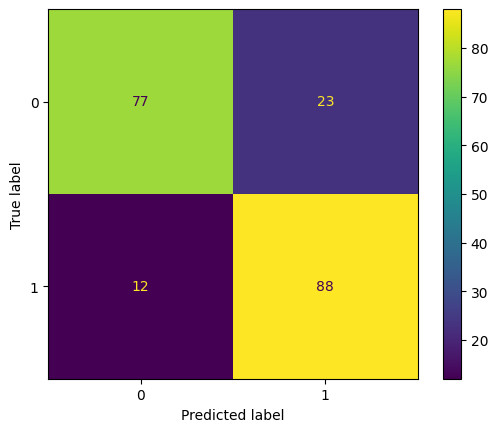

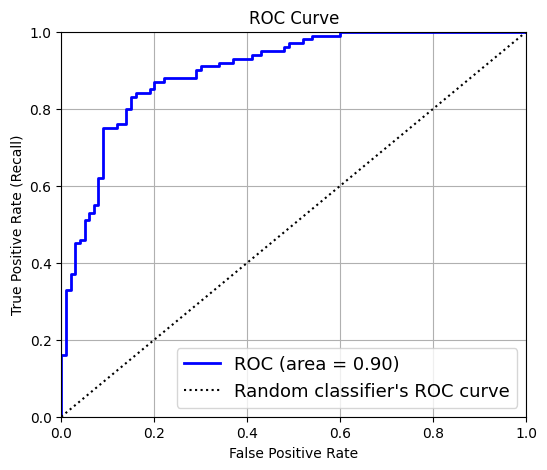

In [30]:
cat_pred = cat_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, cat_pred))
ConfusionMatrixDisplay.from_predictions(y_test, cat_pred)
ml.plot_roc_curve(cat_grid.best_estimator_, X_test, y_test)

## 7.2 Testeo de GradientBoosting

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       100
           1       0.82      0.88      0.85       100

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200

AUC: 0.91


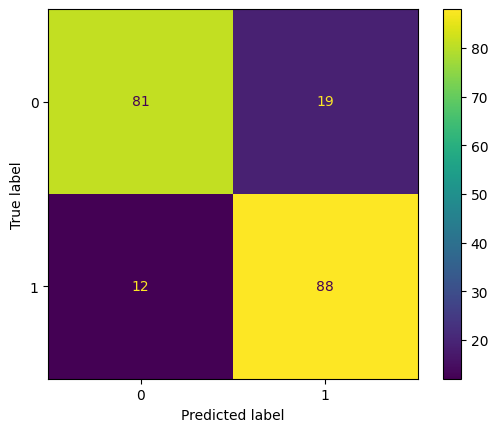

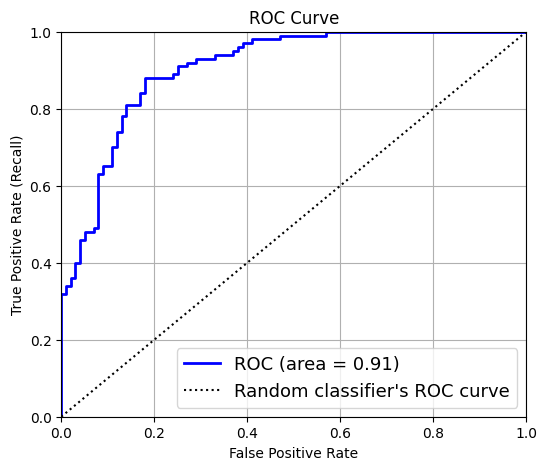

In [35]:
gb_pred = gb_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, gb_pred))
ConfusionMatrixDisplay.from_predictions(y_test, gb_pred)
ml.plot_roc_curve(gb_grid.best_estimator_, X_test, y_test)

## 7.3 Testeo de XGBoost

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       100
           1       0.81      0.88      0.84       100

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.84      0.83      0.83       200

AUC: 0.89


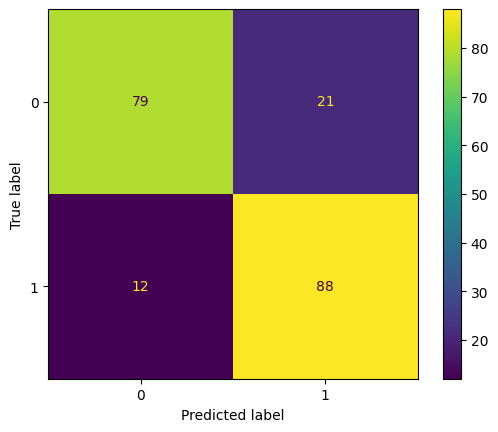

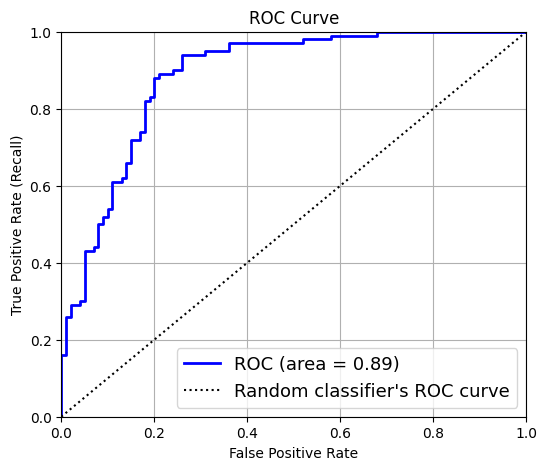

In [36]:
xgb_pred = xgb_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, xgb_pred))
ConfusionMatrixDisplay.from_predictions(y_test, xgb_pred)
ml.plot_roc_curve(xgb_grid.best_estimator_, X_test, y_test)

> NOTA: he tenido que hacer previamente un downgrade de numpy para poder usar CatBoost. Si quiero volver a actualizar numpy, ejecutar la siguiente línea.

In [33]:
# Update de numpy

# !pip install --upgrade numpy